<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
<p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">TABLE OF CONTENTS</p>

* [0. OBJECTIVES and SCOPE](#0)
* [1. IMPORTING LIBRARIES](#1)
* [2. LOADING DATA](#2)    
* [3. DATA PREPARATION](#3)
* [4. EXPLORATORY DATA ANALYSIS](#4)     
* [5. DATA ENGINEERING](#5)
* [6. MODELING](#6)
* [7. EVALUATION](#7)
* [8. DISCUSSION](#8)  
* [9. ENSEMBLES ](#9)
* [10. DEPLOYMENT ](#10)
* [11. END](#11)

<a id='0'></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">OBJECTIVES and SCOPE</p>

[Return to table of contents](#top)

* Objective: The challenge is to recognize fraudulent credit card transactions so that the customers of credit card companies are not charged for items that they did not purchase.

Main challenges involved in credit card fraud detection are:

- Enormous Data is processed every day and the model build must be fast enough to respond to the scam in time.
- Imbalanced Data i.e most of the transactions (99.8%) are not fraudulent which makes it really hard for detecting the fraudulent ones
- Data availability as the data is mostly private.
- Misclassified Data can be another major issue, as not every fraudulent transaction is caught and reported.
- Adaptive techniques used against the model by the scammers.

How to tackle these challenges?

* The model used must be simple and fast enough to detect the anomaly and classify it as a fraudulent transaction as quickly as possible.
* Imbalance can be dealt with by properly using some methods which we will talk about in the next paragraph
* For protecting the privacy of the user the dimensionality of the data can be reduced.
* A more trustworthy source must be taken which double-check the data, at least for training the model.
* We can make the model simple and interpretable so that when the scammer adapts to it with just some tweaks we can have a new model up and running to deploy.

<a id="1"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">IMPORTING LIBRARIES</p>
[Return to table of contents](#top)

In [3]:
# Parameters
path_root = "C:\\Users\\usuario\\Documents\\GitHub\\101MachineLearning"
path_output = f"{path_root}/000_output/"

In [4]:
# Custom libraries
import os
import sys
sys.path.append(f"{path_root}/000_lib")

# from MongoDatabase import MongoDatabase  # type: ignore
from utils_pandas import getDeepKeyValues, typecast_column  # type: ignore
from stats import correlation_heatmap  # type: ignore
from insight import exploreSurface, describeDataset, getMissingAndDuplicates, categorizeColumns  # type: ignore
from evaluation import evaluateClassificationNeuralNetwork, backend_f1_score, backend_precision, backend_recall  # type: ignore
from feature_engineering import * # type: ignore  # bucket_feature  get_any_all_outliers
from pipeline import PA, PipelineCorrelation  # type: ignore
from tuning import tuneModel  # type: ignore
from utils_images import *  # type: ignore remove if there are not images involved

In [5]:
# General libraries
import datetime
from tqdm.notebook import tqdm
from collections import Counter

In [6]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

from textwrap import wrap

In [7]:
# machine learning
from sklearn import linear_model
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn import naive_bayes
from sklearn import tree
from sklearn import naive_bayes
from sklearn import gaussian_process
from sklearn import discriminant_analysis
from sklearn import model_selection
from sklearn import feature_selection
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from xgboost import XGBClassifier

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Sequential, callbacks
from tensorflow.keras.optimizers import Adam

# Hypertunning libraries
import keras_tuner as kt
from sklearn.model_selection import StratifiedKFold, KFold

Using TensorFlow backend


In [8]:
from sklearn.metrics import accuracy_score,classification_report,f1_score

<a id="2"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">LOADING DATA</p>
[Return to table of contents](#top)

## Description

Context
* It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

Content
* The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

## Load

Data location: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download

In [15]:
dataset_raw: pd.DataFrame = pd.read_csv(f"{path_root}/000_data/creditcard.csv")
dataset_raw.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


<a id="3"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">DATA PREPARATION</p>
[Return to table of contents](#top)

## Exploration

In [10]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [11]:
dataset_raw.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [12]:
dataset_raw.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [13]:
exploreSurface(dataset_raw)

,type1,type2,porc_unique,problem,unique_values
Time,numerical,discrete,0.437461,,[]
V1,useless,unknown,0.967894,"High variability, better drop this",[]
V2,useless,unknown,0.967894,"High variability, better drop this",[]
V3,useless,unknown,0.967894,"High variability, better drop this",[]
V4,useless,unknown,0.967894,"High variability, better drop this",[]
V5,useless,unknown,0.967894,"High variability, better drop this",[]
V6,useless,unknown,0.967894,"High variability, better drop this",[]
V7,useless,unknown,0.967894,"High variability, better drop this",[]
V8,useless,unknown,0.967894,"High variability, better drop this",[]
V9,useless,unknown,0.967894,"High variability, better drop this",[]


## Format to make it usable

In [14]:
pipeline_format_actions = {
    0: {
        "Time": [
            [PA.RENAME, "seconds_from_start"]
        ],
    },
}

In [16]:
class PipelineDataFormat:
    """Reusable pipeline to manage data loading and initial preparation: 
    missing, duplicated, names and types. Not advanced engineering
    """
    def __init__(self):
        pass
    
    def handle_missing(self, df:pd.DataFrame):
        return df.dropna(how='all')
    
    def handle_duplicated(self, df:pd.DataFrame):
        return df  # .drop_duplicates(["item"])
    
    def handle_inconsistent(self, df:pd.DataFrame):
        return df  # [mask]
        
    def execute_pipeline_actions(self, df:pd.DataFrame, pipeline_actions:dict):
        df_fit = df.copy()

        layers_pipelines = len(pipeline_actions)

        if layers_pipelines > 0:

            # Layer 1
            df_fit = PA.exec(df_fit, pipeline_actions[0])

            df_fit = self.handle_missing(df_fit)
            df_fit = self.handle_duplicated(df_fit)
            df_fit = self.handle_inconsistent(df_fit)
        
        return df_fit
    
def load_formated(pipeline_format_actions, dataset_raw=None, path=''):
    if dataset_raw is None:
        dataset_raw: pd.DataFrame = pd.read_csv(path)
        # Not store in other memory allocation for performance
    
    return PipelineDataFormat().execute_pipeline_actions(dataset_raw, pipeline_format_actions)

dataset_cur = load_formated(pipeline_format_actions, dataset_raw)
dataset_cur.info()
print(dataset_cur.shape)
dataset_cur.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   seconds_from_start  284807 non-null  float64
 1   V1                  284807 non-null  float64
 2   V2                  284807 non-null  float64
 3   V3                  284807 non-null  float64
 4   V4                  284807 non-null  float64
 5   V5                  284807 non-null  float64
 6   V6                  284807 non-null  float64
 7   V7                  284807 non-null  float64
 8   V8                  284807 non-null  float64
 9   V9                  284807 non-null  float64
 10  V10                 284807 non-null  float64
 11  V11                 284807 non-null  float64
 12  V12                 284807 non-null  float64
 13  V13                 284807 non-null  float64
 14  V14                 284807 non-null  float64
 15  V15                 284807 non-nul

,seconds_from_start,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


<a id="4"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">EXPLORATORY DATA ANALYSIS</p>
[Return to table of contents](#top)

<span style="color:#0affef">Questions</span><br><br>
Before performing EDA, we should have a clear objective. So we can make the right questions and the right visualizations.<br>
* [Q1: What are the most important factors when fraud happen?](#101)
* [Q2: how is the distribution of 'V1..V18' variables?](#102)
* [Q3: Can I use the time to predirct over frauds?](#103)
* [Q4: What kind of problem is this?](#104)
Classification
* [Q5: How is the data balanced?](#105)
Very imbalanced:
- Class: 0 over all 99.83 %
- Class: 1 over all 0.17 %
* [Q6: Which metrics should I use?](#106) AROC -> recall

<br><br>
<span style="color:#0affef">Objectives</span><br>
<hr>
<span style="color:#0affef">1) Reduce frauds </span><br>
<hr>
<span style="color:#0affef">2) Predict frauds </span><br>
<hr>
<span style="color:#0affef">3) Get the correlation between the independent variables and dependent variables </span><br>
<hr>

<hr>

In [17]:
# Playaround section
dataset_cur.head()

,seconds_from_start,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Data understanding

In [18]:
dataset_cur.describe()

,seconds_from_start,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [24]:
class_value_counts = dataset_cur["Class"].value_counts()
print(class_value_counts)
total = class_value_counts[0] + class_value_counts[1]
print(total)
print(f"Class: 0 over all {round(class_value_counts[0]*100/total, 2)} %")
print(f"Class: 1 over all {round(class_value_counts[1]*100/total, 2)} %")

Class
0    284315
1       492
Name: count, dtype: int64
284807
Class: 0 over all 99.83 %
Class: 1 over all 0.17 %


1 means Fraud

## Distributions

In [30]:
# This function is very expensive
pair_plot_columns = [
    "V1",
    "V2",
    "V3",
    "V4",
    "V5",
    "V6",
    "V7",
    "V8",
    "V9",
    "V10",
    "V11",
    "V12",
    "V13",
    "V14",
    "V15",
    "V16",
    "V17",
    "V18",
    "Class"
]
plt.figure()
sns.pairplot(dataset_cur[pair_plot_columns], hue= "Class")
plt.show()

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

Error in callback <function flush_figures at 0x000001DB1C07CDC0> (for post_execute):


KeyboardInterrupt: 

## Outliers/Anomaly Detection

In [31]:
cols_numerical_detect_outliers = [f"V{i}" for i in range(1, 18 + 1)]

matrix_zscore_abs, outliers_any_col, outliers_all_col = get_any_all_outliers(dataset_cur, cols_numerical_detect_outliers)

print(f"Count any outliers: {outliers_any_col.sum()}")
print(f"Count full outliers: {outliers_all_col.sum()}")

outliers_zscore_any = matrix_zscore_abs[outliers_any_col]  # [outliers_any_col, :]
df_outliers = pd.concat(
    [
        dataset_cur.loc[outliers_any_col].reset_index(drop=True), 
        pd.DataFrame(outliers_zscore_any, columns=cols_numerical_detect_outliers).add_prefix("zscore_").reset_index(drop=True)
    ], axis=1
)

del matrix_zscore_abs, outliers_any_col, outliers_all_col, outliers_zscore_any
df_outliers


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [122]:
del df_outliers

## Pivoting

### Numerical

In [48]:
pd.pivot_table(dataset_cur, index = 'Class', values = cols_numerical_detect_outliers, aggfunc="mean")

,V1,V10,V11,V12,V13,V14,V15,V16,V17,V18,V2,V3,V4,V5,V6,V7,V8,V9
Class,,,,,,,,,,,,,,,,,,
0,0.008258,0.009824,-0.006576,0.010832,0.000189,0.012064,0.000161,0.007164,0.011535,0.003887,-0.006271,0.012171,-0.007860,0.005453,0.002419,0.009637,-0.000987,0.004467
1,-4.771948,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123


In [50]:
dataset_cur.describe()

,seconds_from_start,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


          Class
band_V1        
0             1
1        141455
2        143351
3             0


C:\Users\usuario\Documents\GitHub\101MachineLearning/000_lib\feature_engineering.py:164: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_band_age_churn = df[[band_name, target[0]]].groupby([band_name]).count()


,seconds_from_start,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,band_V1
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,1
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,2
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,1
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,1
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,1


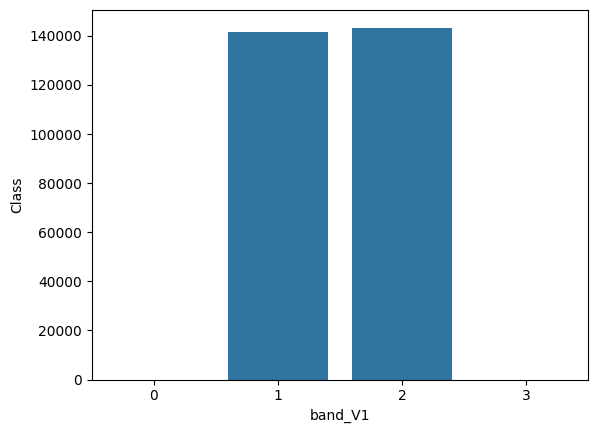

In [57]:
bucket_feature(dataset_cur, "V1", target=["Class"], maximum=3, bins=3, custom_bins_feature=[
    -100, -50, 0, 10, np.inf
]).head()

## Feature engineering analysis

### Correlation

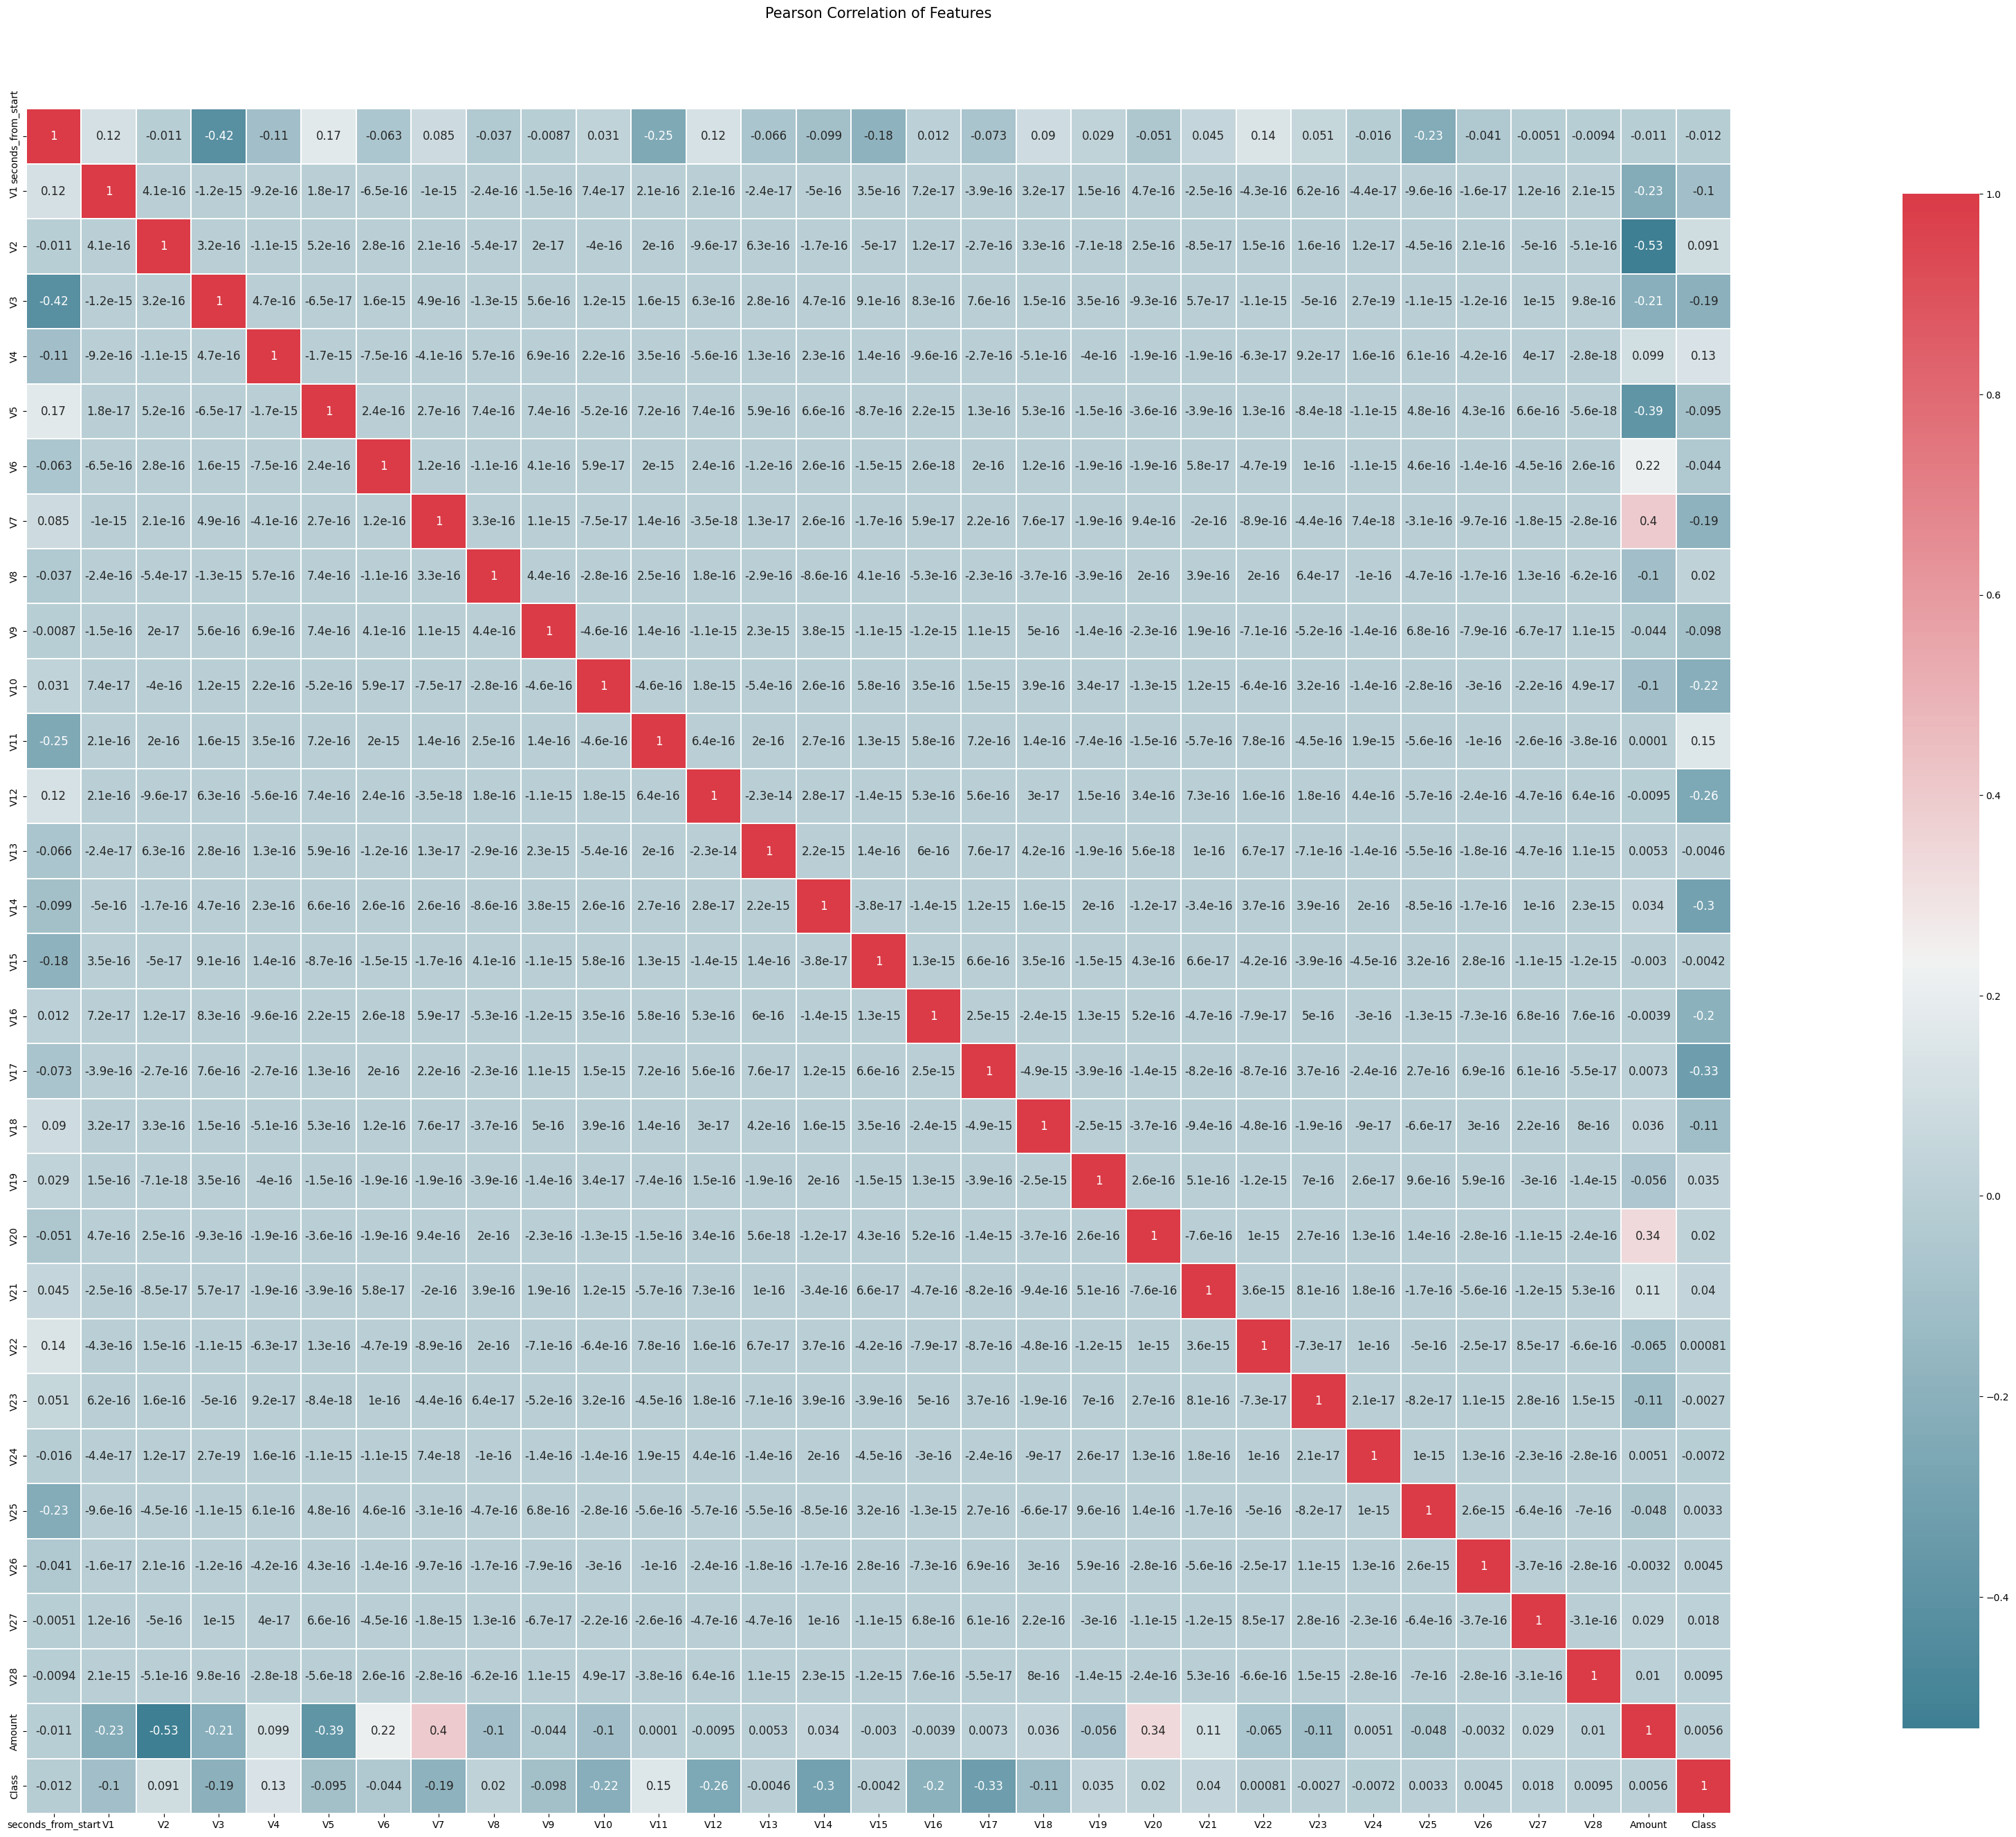

In [59]:
correlation_heatmap(dataset_cur, figsize=(64,32))

### Low variance

In [60]:
low_variance_columns, low_variance_heights = getVarianceLowColumns(dataset_cur, threshold=0.1)
# dataset = dataset.drop(low_variance_columns, axis=1)
# X = dataset.drop('target', axis=1)
# y = dataset['target']
# print(len(X.columns), "variance features")
print(low_variance_columns)
print(low_variance_heights)

['Class']
[0.001724507479019877]


### Multicolinear analysis

In [62]:
# Multicolinearity
multicolinear_columns = getMulticolinearColumns(dataset_cur.corr(), keep_features_min = 10)
# X = X.drop(multicolinear_columns, axis=1)
print("Multicolinearity features", multicolinear_columns)

Multicolinearity features []


### Low correlation with target

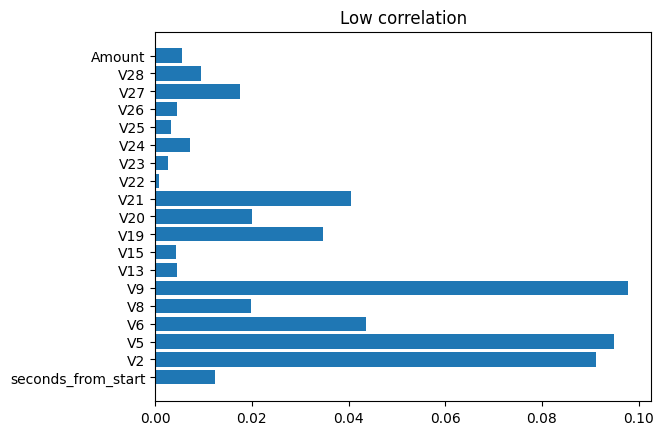

low_correlations_labels ['seconds_from_start', 'V2', 'V5', 'V6', 'V8', 'V9', 'V13', 'V15', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


In [63]:
X = dataset_cur.drop(columns=["Class"])
y = dataset_cur.loc[:, "Class"]
# Low correlation
low_correlations_labels, low_correlations_abs = getLowCorrelationsWithTarget(
    X, y, min_correlation=0.1
)
# X = X.drop(low_correlations_labels, axis=1)
plt.barh(low_correlations_labels, low_correlations_abs)
plt.title("Low correlation")
plt.show()
print("low_correlations_labels", low_correlations_labels)

### Feature importance

In [64]:
number_features_to_select = int(len(X.columns) * 0.8)

# Important features, the 80% most important
if number_features_to_select > 0 and number_features_to_select < len(X.columns):
    features_important = getImportantFeatures(X, y, number_features_to_select, max_features = 6)
    print(features_important)
    print(number_features_to_select, "important features")
    # X = X.loc[:,features_important]
else:
    print("No important features selected")

KeyboardInterrupt: 

## Insights

* Some features have outliers
* The is low correlation with class, some features could be ignored

<a id="5"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">DATA ENGINEERING</p>
[Return to table of contents](#top)

In [65]:
def load_split_clean_Xy(pipelineDataEngineering, df:pd.DataFrame, target=[], random_state=42,test_size=0.2):
    X = df.drop(columns=target)
    y = df.loc[:, target]
    # print(X.shape, y.shape)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y,random_state=random_state,test_size=test_size)

    X_train, y_train = pipelineDataEngineering.transform(X_train, y_train)
    X_test, _ = pipelineDataEngineering.transform(X_test)
    y_test = y_test.to_numpy()
    del X, y
    X = np.concatenate([X_train,X_test], axis=0)
    y = np.concatenate([y_train,y_test], axis=0)
    
    return X, y, X_train, y_train, X_test, y_test

In [70]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
import math

class PipelineDataEngineering:
    
    def __init__(self, columns_scale, cast_to_numpy=True, target=[], dimension_reduction_to=-1, is_imbalanced=False) -> None:
        self.mask_importances = []
        self.dimension_reduction_to = dimension_reduction_to
        self.target = target
        self.columns_scale = columns_scale
        self.cast_to_numpy = cast_to_numpy
        self.is_imbalanced = is_imbalanced

    def featureEngineering(self, X_raw:pd.DataFrame, y=None):
        """Feature processing

        Args:
            X_raw (pd.DataFrame): _description_
            y (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        X_clean = X_raw.copy()

        X_clean["seconds_from_start_sin"] = X_clean["seconds_from_start"].apply(math.sin)

        X_clean = X_clean.drop(columns=[
            "seconds_from_start"
            ]
        )
        
        return X_clean, y

    def processOutliers(self, X_raw:pd.DataFrame, y=None):
        """Remove rows not useful

        Args:
            X_raw (pd.DataFrame): _description_
            y (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        # X_clean = X_raw.copy()
        # y_clean = y.copy()
        
        return X_raw, y

    def scaleData(self, X_raw:pd.DataFrame, y=None):
        """Scale data with StandardScaler

        Args:
            X_raw (pd.DataFrame): _description_
            y (_type_, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        if len(self.columns_scale) == 0:
            return X_raw, y
        #Scaling
        scaler = StandardScaler()
        X_raw[self.columns_scale] = scaler.fit_transform(X_raw[self.columns_scale])
        self.scaler = scaler
        return X_raw, y


    def reduceDimension(self, X_raw:pd.DataFrame, y:pd.DataFrame=None):
        """Reduce dimension with PCA

        Args:
            X_raw (pd.DataFrame): _description_
            y (pd.DataFrame, optional): _description_. Defaults to None.

        Returns:
            _type_: _description_
        """
        # Usually PCA or feature importance with random forests
        
        if self.dimension_reduction_to == -1:
            return X_raw, y

        #Initiating PCA to reduce dimentions aka features to 3
        pca = PCA(n_components=self.dimension_reduction_to)
        pca.fit(X_raw)

        columns = [f"col{i}" for i in range(1,self.dimension_reduction_to+1)]

        PCA_ds = pd.DataFrame(pca.transform(X_raw), columns=(columns))
        return PCA_ds, y
    
    def process_imbalanced(self, X_raw:pd.DataFrame, y=None):
        """Process imbalanced class with SMOTE

        Args:
            X_raw (pd.DataFrame): _description_
            y (pd.DataFrame, optional): _description_. Defaults to None.

        Returns:
            (pd.DataFrame,pd.DataFrame): _description_
        """
        if not self.is_imbalanced or y is None:
            return X_raw, y

        smote = SMOTE()
        X_smote, Y_smote =smote.fit_resample(X_raw, y)
        
        return X_smote, Y_smote

        
    def transform(self, X_raw:pd.DataFrame, y:pd.DataFrame=None):
        """Pass y only if is the trainig dataset. Otherwise (testing,val,etc)
        only pass X_raw

        Args:
            X_raw (pd.DataFrame): Features dataset
            y (pd.DataFrame, optional): the labels. Defaults to None.

        Returns:
            (X_clean, y_clean): numpy array or dataframe with data processed.
        """
        
        X_clean = X_raw.copy()
        
        if y is not None:
            y_clean = y.copy()
        else:
            y_clean = None
        
        X_clean, y_clean = self.featureEngineering(X_clean, y_clean)
        
        X_clean, y_clean = self.processOutliers(X_clean, y_clean)
        
        # Data is consumable and prepared
        if self.is_imbalanced and y is not None:
            # Training, change imbalanced with smote
            X_clean, y_clean = self.process_imbalanced(X_clean, y_clean)
            pass
            
        # Scale for fast training
        X_clean, y_clean = self.scaleData(X_clean, y_clean)
        
        # Reduce dimensions to discard not too useless features
        X_clean, y_clean = self.reduceDimension(X_clean, y_clean)
        
        if self.cast_to_numpy:
            if y_clean is not None:
                return X_clean.to_numpy(), y_clean.to_numpy()
            return X_clean.to_numpy(), y_clean
                
        return X_clean, y_clean
    
    def evaluate(self, model, X, y):
        cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

        return model_selection.cross_validate(model, X, y, cv  = cv_split)

pipelineDataEngineering = PipelineDataEngineering(
    [
        "V1",
        "V2",
        "V3",
        "V4",
        "V5",
        "V6",
        "V7",
        "V8",
        "V9",
        "V10",
        "V11",
        "V12",
        "V13",
        "V14",
        "V15",
        "V16",
        "V17",
        "V18",
        "seconds_from_start_sin",
        "Amount"
    ],
    target=["Class"],
    dimension_reduction_to=-1,
    is_imbalanced=True,
    cast_to_numpy=True
)
    
dataset_cur = load_formated(pipeline_format_actions, dataset_raw)

X, y, X_train, y_train, X_test, y_test = load_split_clean_Xy(pipelineDataEngineering, dataset_cur, target=["Class"])
# del dataset_raw
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
y = y.reshape((len(y)))

model = ensemble.RandomForestClassifier(n_estimators=100)
cv_evaluation = pipelineDataEngineering.evaluate(model, X[0:1000, :], y[0:1000])
test_score = cv_evaluation["test_score"]
print(f"JUST DEBUG ACCURACY: range score: {round(test_score.min(),2)}-{round(test_score.max(),2)}")
# plt.plot(test_score)
del model

(454902, 30) (454902, 1) (56962, 30) (56962, 1)
JUST DEBUG ACCURACY: range score: 0.99-1.0


SMOTE DISTRIBUTION FOR TRAINING. Normal for testing


<BarContainer object of 4 artists>

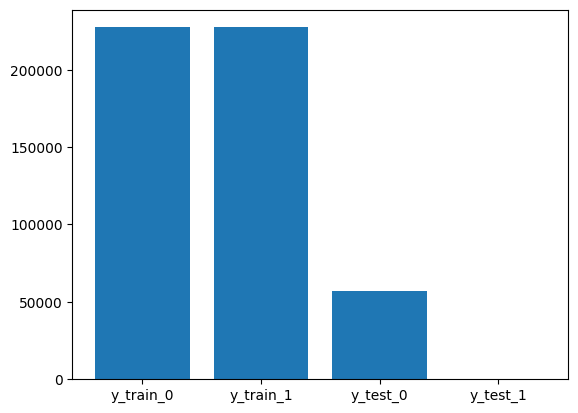

In [73]:
y_train_sum = y_train.sum()
y_test_sum = y_test.sum()
print("SMOTE DISTRIBUTION FOR TRAINING. Normal for testing")
plt.bar(["y_train_0", "y_train_1","y_test_0", "y_test_1"], [len(y_train) - y_train_sum, y_train_sum, len(y_test) - y_test_sum, y_test_sum])

<a id="6"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">MODELING</p>
[Return to table of contents](#top)

## MLA recap:


### Ensemble Methods
* AdaBoost is best used to boost the performance of decision trees on binary classification problems.

->ensemble.AdaBoostClassifier(),

* Bagging classifier helps reduce the variance of individual estimators by sampling technique and combining the predictions. Consider using bagging classifier for algorithm which results in unstable classifiers (classifier having high variance). For example, decision tree results in construction of unstable classifier having high variance and low bias.

-> ensemble.BaggingClassifier(),

* Decision Trees ensemble. Trees use the whole original sample. Extra Trees chooses optimal randomly. Is faster than random forest.

-> ensemble.ExtraTreesClassifier(),

* Gradient boosting classifiers are a group of machine learning algorithms that combine many weak learning models together to create a strong predictive model. Decision trees are usually used when doing gradient boosting. Has other version improvements as x*Boost

-> ensemble.GradientBoostingClassifier(),

* Decision Trees ensemble. Uses bootstrap replicas, that is to say, it subsamples the input data with replacement. Random Forest chooses the optimum split

-> ensemble.RandomForestClassifier(),

### Gaussian Processes
* They are a type of kernel model, like SVMs, and unlike SVMs, they are capable of predicting highly calibrated class membership probabilities, although the choice and configuration of the kernel used at the heart of the method can be challenging. The Gaussian Processes Classifier is a non-parametric algorithm that can be applied to binary classification tasks.

-> gaussian_process.GaussianProcessClassifier(),

### GLM

* Binary classification. Basic assumptions that must be met for logistic regression include independence of errors, linearity in the logit for continuous variables, absence of multicollinearity, and lack of strongly influential outliers. Logistic regression is easier to implement, interpret, and very efficient to train. Accuracy may not be the best

-> linear_model.LogisticRegressionCV(),


* Passive-Aggressive algorithms are generally used for large-scale learning. It is one of the few ‘online-learning algorithms‘.  In online machine learning algorithms, the input data comes in sequential order and the machine learning model is updated step-by-step, as opposed to batch learning, where the entire training dataset is used at once. This is very useful in situations where there is a huge amount of data and it is computationally infeasible to train the entire dataset because of the sheer size of the data. We can simply say that an online-learning algorithm will get a training example, update the classifier, and then throw away the example. Passive-Aggressive algorithms are somewhat similar to a Perceptron model, in the sense that they do not require a learning rate. However, they do include a regularization parameter. Passive: If the prediction is correct, keep the model and do not make any changes. i.e., the data in the example is not enough to cause any changes in the model. Aggressive: If the prediction is incorrect, make changes to the model. i.e., some change to the model may correct it.

-> linear_model.PassiveAggressiveClassifier(),

* RidgeClassifier() works differently compared to LogisticRegression() with l2 penalty. The loss function for RidgeClassifier() is not cross entropy. Is general used for binary classification. But for multi class clasification: Use LabelBinarizer() to create a multi-output regression scenario, and then train independent Ridge() regression models, one for each class (One-Vs-Rest modelling). How works: Convert target variable into +1 or -1 based on the class in which it belongs to. Build a Ridge() model (which is a regression model) to predict our target variable. The loss function is MSE + l2 penalty. If the Ridge() regression's prediction value (calculated based on decision_function() function) is greater than 0, then predict as positive class else negative class.

-> linear_model.RidgeClassifierCV(),

* Why do we use SGD classifiers, when we already have linear classifiers such as LogReg or SVM?, As we can read from the previous text, SGD allows minibatch (online/out-of-core) learning. Therefore, it makes sense to use SGD for large scale problems where it’s very efficient. Another reason to use SGD Classifier is that SVM or logistic regression will not work if you cannot keep the record in RAM. However, SGD Classifier continues to work.

-> linear_model.SGDClassifier()

* Like logistic regression, it can quickly learn a linear separation in feature space for two-class classification tasks, although unlike logistic regression, it learns using the stochastic gradient descent optimization algorithm and does not predict calibrated probabilities. The Perceptron Classifier is a linear algorithm that can be applied to binary classification tasks. Is a basic version of neural network. Definetly not deep learning.

-> linear_model.Perceptron(),
 
### Navies Bayes
* Why is it called Naive? It is called Naive because of the assumption that 2 variables are independent when they may not be. In a real-world scenario, there is hardly any situation where the features are independent. Since it is a probabilistic approach, the predictions can be made real quick. It can be used for both binary and multi-class classification problems. Assumptions: All the variables are independent. That is if the animal is Dog that doesn’t mean that Size will be Medium, All the predictors have an equal effect on the outcome. That is, the animal being dog does not have more importance in deciding If we can pet him or not. All the features have equal importance, 
* Gaussian Naïve Bayes is used when we assume all the continuous variables associated with each feature to be distributed according to Gaussian Distribution. Gaussian Distribution is also called Normal distribution.

-> naive_bayes.GaussianNB(),

*  Used for discrete data, where features are only in binary form. it is very useful to use in a binary distribution where the output label may be present or absent. he main advantage of this algorithm is that it only accepts features in the form of binary values. It is very fast compared to other classification algorithms. Sometimes machine learning algorithms do not work well if the dataset is small, but this is not the case with this algorithm because it gives more accurate results compared to other classification algorithms in the case of a small dataset. It’s fast and can also handle irrelevant features easily.

-> naive_bayes.BernoulliNB(),

### Nearest Neighbor
* Useful for classification and regresion. In order for this model to work the data must have a notion of distance. In laymens terms, we need to be able to graph our data. This model will is non-linear and can be used on classes. What I mean by classes is it can help determine if a data point will be part of one class or another. It just classifies a data point based on its few nearest neighbors. KNN is a non-parametric algorithm because it does not assume anything about the training data. This makes it useful for problems having non-linear data. KNN can be computationally expensive both in terms of time and storage, if the data is very large because KNN has to store the training data to work. This is generally not the case with other supervised learning models. KNN can be very sensitive to the scale of data as it relies on computing the distances. For features with a higher scale, the calculated distances can be very high and might produce poor results. It is thus advised to scale the data before running the KNN. Used in recommendation sistems, smantic search, anomaly detection. How it works: calculates the distance between the item to clasify and the other items in the training, select the k elements with less distance, make them k to vote and we choose the final prediction. More K may not be the same as better precision.

-> neighbors.KNeighborsClassifier(n_neighbors=3),

### SVM
* SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces. VM is one of the best classifier but not the best. In fact, no one could be the best.  It depends upon the problem which classifier would be suitable. Suitable When number of features (variables) and number of training data is very large (say millions of features and millions of instances (data)), When sparsity in the problem is very high, i.e., most of the features have zero value, It is the best for document classification problems where sparsity is high and features/instances are also very high, It also performs very well for problems like image classification, genes classsification, drug disambiguation etc. where number of features are high. We may want to start with SVC and them optimice with other two or come back to SVC.

*  The main difference is that SVC uses the parameter C. C-Support Vector Classification. Regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty.

-> svm.SVC(probability=True),

* nuSVC uses the parameter nu. Similar to SVC but uses a parameter to control the number of support vectors. nu is An upper bound on the fraction of margin errors (see User Guide) and a lower bound of the fraction of support vectors. Should be in the interval (0, 1].

-> svm.NuSVC(probability=True),

* LinearSVC is similar to SVC with parameter kernel='linear'. With extended penalties and loss functions.

-> svm.LinearSVC(),

### Trees
*  tree algorithm can be used for solving regression and classification problems too. Faster than ensemble Random forest. Less accurate

-> tree.DecisionTreeClassifier(),

* Faster than decision tree. This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

-> tree.ExtraTreeClassifier(),

### Discriminant Analysis
* is a dimensionality reduction technique that is commonly used for supervised classification problems. It is used for modelling differences in groups i.e. separating two or more classes. It is used to project the features in higher dimension space into a lower dimension space.  For example, we have two classes and we need to separate them efficiently. Classes can have multiple features. Using only a single feature to classify them may result in some overlapping. So, we will keep on increasing the number of features for proper classification. 

-> discriminant_analysis.LinearDiscriminantAnalysis(),

* QDA is a variant of LDA in which an individual covariance matrix is estimated for every class of observations. QDA is particularly useful if there is prior knowledge that individual classes exhibit distinct covariances. A disadvantage of QDA is that it cannot be used as a dimensionality reduction technique.

-> discriminant_analysis.QuadraticDiscriminantAnalysis(),

### xgboost
* XGBoost is a tree based ensemble machine learning algorithm which is a scalable machine learning system for tree boosting. Useful When you have large number of observations in training data, Number features < number of observations in training data, It performs well when data has mixture numerical and categorical features or just numeric features, When the model performance metrics are to be considered. Using Random Forest generates many trees, each with leaves of equal weight within the model, in order to obtain higher accuracy. On the other hand, Gradient Descent Boosting introduces leaf weighting to penalize those that do not improve the model predictability. Both decision tree algorithms generally decrease the variance, while boosting also improves the bias.

-> XGBClassifier(eval_metric='mlogloss')

### Clustering

* Used to get the K. Or cluster itself.

-> KMeans(n_clusters=k)

* Better performance than KMeans.

-> AC = AgglomerativeClustering(n_clusters=4)
-> yhat_AC = AC.fit_predict(X_train)
-> X_clean["Clusters"] = yhat_AC

NN used for multiple output prediction, with a lot of data, big input feature, etc.

## Baseline

In [74]:
# Bias: predict 0 to everything
(y_test == 0).sum() / len(y_test)

0.9982795547909132

## Brief selected models evaluation

In [75]:
def fit_evaluate(name, model, X_train_sample, y_train_sample, X_test_sample, y_test_sample):
    print(name)
    model.fit(X_train_sample, y_train_sample)
    y_pre_RF=model.predict(X_test_sample)
    print(accuracy_score(y_test_sample, y_pre_RF))
    print(classification_report(y_test_sample, y_pre_RF))
    return model

In [76]:
samples_train = 2000
samples_test = 1000

X_train_sample = X_train[0:samples_train, :]
y_train_sample = y_train[0:samples_train, :]
X_test_sample = X_test[0:samples_test, :]
y_test_sample = y_test[0:samples_test, :]
y_train_sample = y_train_sample.reshape((len(y_train_sample)))
y_test_sample = y_test_sample.reshape((len(y_test_sample)))

model_dt = tree.DecisionTreeClassifier()
model_svm = svm.SVC(probability=True)
model_rf = ensemble.RandomForestClassifier(n_estimators=1000)
model_xgb = XGBClassifier(eval_metric='mlogloss')
fit_evaluate("Decision Tree", model_dt, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
fit_evaluate("SVC", model_svm, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
fit_evaluate("Random Forest", model_rf, X_train_sample, y_train_sample, X_test_sample, y_test_sample)
fit_evaluate("XGBooster", model_xgb, X_train_sample, y_train_sample, X_test_sample, y_test_sample)

del X_train_sample, y_train_sample, X_test_sample, y_test_sample

Decision Tree
0.761
              precision    recall  f1-score   support

           0       1.00      0.76      0.86       998
           1       0.01      1.00      0.02         2

    accuracy                           0.76      1000
   macro avg       0.50      0.88      0.44      1000
weighted avg       1.00      0.76      0.86      1000

SVC
0.998
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       998
           1       0.00      0.00      0.00         2

    accuracy                           1.00      1000
   macro avg       0.50      0.50      0.50      1000
weighted avg       1.00      1.00      1.00      1000

Random Forest


c:\Users\usuario\anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\usuario\anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\usuario\anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.989
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       998
           1       0.15      1.00      0.27         2

    accuracy                           0.99      1000
   macro avg       0.58      0.99      0.63      1000
weighted avg       1.00      0.99      0.99      1000

XGBooster
0.977
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       998
           1       0.08      1.00      0.15         2

    accuracy                           0.98      1000
   macro avg       0.54      0.99      0.57      1000
weighted avg       1.00      0.98      0.99      1000



- Keep: RF, SVC and XGB

## Gaussian mixture

N/A

In [ ]:
X_all = np.concatenate((X.copy().to_numpy(), X_submission), axis=0)

lowest_bic = np.infty
bic = []
n_components_range = range(1, 7)
cv_types = ['spherical', 'tied', 'diag', 'full']

for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X_all)
        bic.append(gmm.aic(X_all))
        
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
            
best_gmm.fit(X_all)

gmm_X_train = best_gmm.predict_proba(X_train)
gmm_X_test = best_gmm.predict_proba(X_test)
gmm_X_submission = best_gmm.predict_proba(X_submission)


In [140]:
### We can use Gaussian mixture
gmm_X_train = X_train
gmm_X_test = X_test

## MLA tunning

In [78]:
n_splits = 5
# Stratified is useful for classification
cv = model_selection.RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=3, random_state=1)
# Useful for regression
# cv = model_selection.RepeatedKFold(n_splits=n_splits, n_repeats=3, random_state=1)

class ModelSearch:
     
     def __init__(self, name, model, space, cv_split=None):
          self.name = name
          self.model = model
          self.space = space
          
          if cv_split is None:
               # This is much faster than repeated
               self.cv = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%
          else:
               self.cv = cv_split

     def tune(self, X_all, y_all, method="grid", n_iter_random=100)->dict:
          initial_crossvalidation = model_selection.cross_validate(self.model, X_all, y_all, cv=self.cv)
          print(f"{self.name} Initial cross validation {initial_crossvalidation}\n")
          search = None
          if method.lower().startswith("random"):
               search = model_selection.RandomizedSearchCV(self.model, self.space, n_iter=n_iter_random, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
          else:
               search = model_selection.GridSearchCV(self.model, param_grid=self.space, scoring = 'roc_auc', cv = self.cv)
          
          search_result = search.fit(X_all, y_all)
          
          results:dict = {
               "name": self.name,
               "evaluation_cv_initial": initial_crossvalidation,
               "evaluation_search_best": search_result.best_score_,
               "best_params": search_result.best_params_,
               "search": search,
               "search_result": search_result
          }
          
          return results
     
models_search = [
     ModelSearch(
          "RandomForest", ensemble.RandomForestClassifier(),
          {
               "n_estimators" : [100, 1000],
               'max_depth': [4,10,None],
               'random_state': [0]
          }, cv
     ),
     ModelSearch(
          "XGBoost", XGBClassifier(),
          {
               'loss' : ["deviance"],
               'n_estimators' : [100,400],
               'learning_rate': [0.01,0.001],
               #'max_depth': [4, 8],
               # 'min_samples_leaf': [100,150],
               #'max_features': [0.3,0.1] 
          }, cv
     )
]


In [79]:
results = []
for ms in models_search:
    results.append(ms.tune(X, y))
print(results)

KeyboardInterrupt: 

### Kfold

In [72]:
skfold = StratifiedKFold(n_splits=10, shuffle=True)

best_score = -1
model_nn = None
history = None

# The general X_test and X_train will be selected here?

for index_train, index_test in skfold.split(X, y):
    split_model = build_model(best_hp)

    split_X_train = X[index_train]
    split_y_train = y[index_train]
    split_X_test = X[index_test]
    split_y_test = y[index_test]
    
    h = split_model.fit(split_X_train, split_y_train, batch_size=BATCH_SIZE, verbose=0, epochs=EPOCHS, validation_split=0.1)
    evaluation = split_model.evaluate(split_X_test, split_y_test)
    acc = evaluation[1]
    
    if acc > best_score:
        best_score = acc
        model_nn = split_model
        history = h.history
        X_test = split_X_test
        y_test = split_y_test
        print(f"Best score: {acc}")
    

46/46 [==============================] - 0s 3ms/step - loss: 0.3366 - accuracy: 0.8546 - backend_f1_score: 0.6696
Best score: 0.854619562625885
46/46 [==============================] - 0s 2ms/step - loss: 0.3076 - accuracy: 0.8594 - backend_f1_score: 0.7020
Best score: 0.859375
46/46 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8661 - backend_f1_score: 0.7058
Best score: 0.8660774827003479
46/46 [==============================] - 0s 2ms/step - loss: 0.2863 - accuracy: 0.8817 - backend_f1_score: 0.7410
Best score: 0.8817130923271179
46/46 [==============================] - 0s 2ms/step - loss: 0.3142 - accuracy: 0.8532 - backend_f1_score: 0.6840


<a id="7"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">EVALUATION</p>
[Return to table of contents](#top)

Evaluate business requerments and models comparations

In [73]:
model_selection.cross_validate(model_rf, X, y, cv  = cv)['test_score']

array([0.87584957, 0.87743543, 0.86678749, 0.8790213 , 0.87698233,
       0.87086543, 0.87131853, 0.88377889, 0.87494336, 0.8676937 ])

<a id="8"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">DISCUSSION</p>
[Return to table of contents](#top)

## Profiling

## Report

## Conclusions
- 

<a id="9"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">ENSEMBLES</p>
[Return to table of contents](#top)

In [70]:
# why choose one model, when you can pick them all with voting classifier
#http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#removed models w/o attribute 'predict_proba' required for vote classifier and models with a 1.0 correlation to another model
vote_est = [
    ('xgd', model_xgb),
    ('svc', model_svm),
    ('rf', model_rf),
    # ('nn', model_nn)
]

Hard Voting Test w/bin score mean: 86.50
Soft Voting Test w/bin score mean: 86.71


In [ ]:
#Hard Vote or majority rules
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
print("Hard Voting cross validation")
vote_hard_cv = model_selection.cross_validate(vote_hard, X, y, cv =cv)
print("Hard Voting fit")
vote_hard.fit(X, y)
print("Hard voting cv scores", vote_hard_cv['test_score'])
print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))

In [ ]:

#Soft Vote or weighted probabilities
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
print("Soft Voting cross validation")
vote_soft_cv = model_selection.cross_validate(vote_soft, X, y, cv  = cv_split)
print("Soft Voting fit")
vote_soft.fit(X, y)
print("Soft voting cv scores", vote_soft_cv['test_score'])
print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))


<a id="10"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">DEPLOYMENT</p>
[Return to table of contents](#top)

In [ ]:
y_submission = knn_best.predict(gmm_X_submission)
knn_best_pred = pd.DataFrame(data={
    'Id': np.arange(1, len(y_submission) + 1),
    'Solution': y_submission
})
knn_best_pred.to_csv('submission.csv', index=False)

<a id="11"></a>
# <p style="background-color:#15ebe3;font-family:newtimeroman;color:#000;font-size:150%;text-align:center;border-radius:10px 10px;">END</p>

[Return to table of contents](#top)